In [26]:
%autosave 0

Autosave disabled


## Homework
Tarasenko Sergii

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, auc, roc_curve
from tqdm.auto import tqdm

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [4]:
df['card'] = (df['card'] == 'yes').astype(int)

In [5]:
df.describe(include='all').round(2).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
card,1319.0,NaN,NaN,NaN,0.78,0.42,0.0,1.0,1.0,1.0,1.0
reports,1319.0,NaN,NaN,NaN,0.46,1.35,0.0,0.0,0.0,0.0,14.0
age,1319.0,NaN,NaN,NaN,33.21,10.14,0.17,25.42,31.25,39.42,83.5
income,1319.0,NaN,NaN,NaN,3.37,1.69,0.21,2.24,2.9,4.0,13.5
share,1319.0,NaN,NaN,NaN,0.07,0.09,0.0,0.0,0.04,0.09,0.91
expenditure,1319.0,NaN,NaN,NaN,185.06,272.22,0.0,4.58,101.3,249.04,3099.5
owner,1319,2,no,738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
selfemp,1319,2,no,1228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,1319.0,NaN,NaN,NaN,0.99,1.25,0.0,0.0,1.0,2.0,6.0
months,1319.0,NaN,NaN,NaN,55.27,66.27,0.0,12.0,30.0,72.0,540.0


In [6]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

In [7]:
df_train.shape, df_val.shape, df_test.shape

((791, 11), (264, 11), (264, 11))

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share` +

In [8]:
q1_var = [
    'reports',
    'dependents',
    'active',
    'share',
]

In [9]:
for i in q1_var:
    print(i, roc_auc_score(y_train, df_train[i]).round(2))

reports 0.28
dependents 0.47
active 0.6
share 0.99


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [10]:
columns_selected = ["reports",
                   "age",
                   "income",
                   "share",
                   "expenditure",
                   "dependents",
                   "months",
                   "majorcards",
                   "active",
                   "owner",
                   "selfemp"]

In [11]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[columns_selected].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[columns_selected].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [12]:
model = LogisticRegression(solver="liblinear",
                           C=1.0,
                           max_iter=1000,
#                            random_state=1,
                          ).fit(X_train, y_train)

In [13]:
y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995 +

In [14]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.995171242063847

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3 +
* 0.6
* 0.8

In [15]:
# the same in scklearn
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    r = recall_score(y_val, y_pred >= t)
    p = precision_score(y_val, y_pred >= t)
    
    scores.append((t, p, r))

In [16]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))

In [17]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

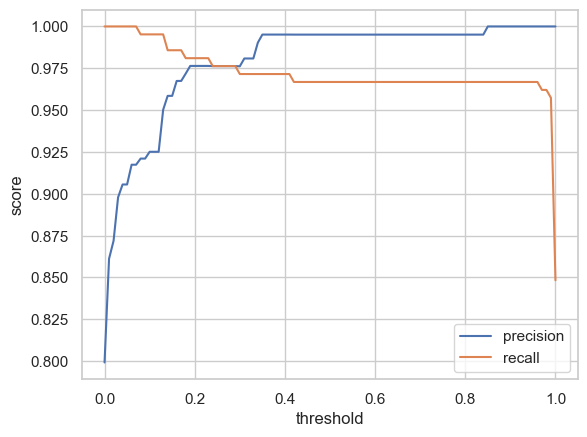

In [18]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend();

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4 +
- 0.6
- 0.7

In [19]:
def f1_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        f1 = 2 * p * r / (p + r)
        scores.append((t, f1))

    columns = ['threshold', 'f1']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores.sort_values('f1', ascending=False).head(10)

In [20]:
f1_dataframe(y_val, y_pred)

,threshold,f1
39,0.39,0.983213
38,0.38,0.983213
37,0.37,0.983213
36,0.36,0.983213
35,0.35,0.983213
41,0.41,0.983213
40,0.40,0.983213
88,0.88,0.983133
85,0.85,0.983133
86,0.86,0.983133


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003 +
- 0.014
- 0.09
- 0.24

In [21]:
def train(df, y_train, C=1.0):
    dicts = df[columns_selected].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [22]:
def predict(df, dv, model):
    dicts = df[columns_selected].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_train_full)):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [24]:
np.std(scores).round(3)

0.003

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1 +
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [25]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.995 +- 0.004
C=0.1 0.997 +- 0.003
C=1 0.996 +- 0.003
C=10 0.997 +- 0.003


## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one

## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.